# Simple AEM toolbox - Basic Tutorial

In this tutorial, we will demonstrate the basic use of our AEM toolbox. For uses of the accompanying MCMC script, please refer to the [Synthetic Test Case](https://github.com/MaxRamgraber/Simple-AEM-Toolbox/tree/main/Tutorials/synthetic_reference) in the Tutorials directory. Before we get started, do not forget to copy the [toolbox_AEM.py](https://github.com/MaxRamgraber/Simple-AEM-Toolbox/blob/main/toolbox_AEM.py) into your user working directory, else the import and model specifications below will not work!

First off, we import a number of libraries: `numpy` for diverse array-related means, `pyplot` for plotting, and of course our `toolbox_AEM`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox_AEM import *

We then start by initializing a base model. This is done by initializing a 'Model' object. For this object, the most common things we can specify are:

 - `head_offset` - elevation of the aquifer base in [length units]
 - `aquifer_type` - whether the aquifer is 'unconfined', 'confined', or 'convertible' (confined/unconfined based on head)
 - `domain_center` - xy coordinates of the center point of the circular model domain in [length units]
 - `domain_radius` - radius of the circular model domain in [length units]

In [2]:
ml  = Model(
    head_offset     = 100,
    aquifer_type    = 'unconfined',
    domain_center   = [1000,1000],
    domain_radius   = 1000)

The Model object has an in-built plot function which allows us to plot its extent and any elements we have defined so far. Let's test it:

Text(0, 0.5, '$y$ coordinate in [length units]')

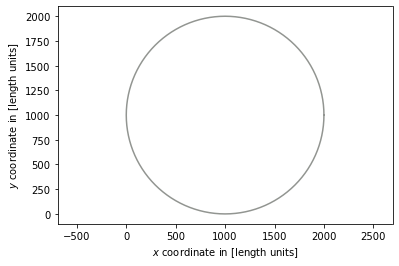

In [3]:
ml.plot()
plt.axis('equal')
plt.xlabel('$x$ coordinate in [length units]')
plt.ylabel('$y$ coordinate in [length units]')

As expected, the current model consists only of the extent of the domain and nothing else, as we haven't added any elements to the model yet. We can start by adding a base flow element. In this toolbox, we have implemented two different forms of base flow: uniform, and Möbius. 

## Möbius Base Flow

Let us implement a Möbius base flow element. The standard parameters we need to specify are:

 - `model`           - the model object to which this element will be added
 - `r`               - position of the three control point images of A, B, and C on the unit circle in terms of radians; their original positions are [-0.25,0.25,0.75]*pi; inflow occurs between point A and B, outflow occurs between point C and D; point D is defined by the specification of A, B and C
 - `head_min`        - hydraulic head at the Möbius outflow in [length units], assigned between C and D
 - `head_max`        - hydraulic head at the Möbius inflow in [length units], assigned between A and B
 - `k`               - background hydraulic conductivity in [length units]/[time units]
 - `use_SC`          - a flag which defines whether the Schwarz-Christoffel transformation is used or not. See Figure 2 in the accompanying manuscript for an illustration of the effect of the Schwarz-Christoffel transformation.

In [4]:
ElementMoebiusBase(
    model           = ml,
    r               = np.asarray([-0.6*np.pi,0.2*np.pi,0.6*np.pi]),
    head_min        = 120,
    head_max        = 130,
    k               = 1E-4,
    use_SC          = False)

Let's plot the progress:

Text(0, 0.5, '$y$ coordinate in [length units]')

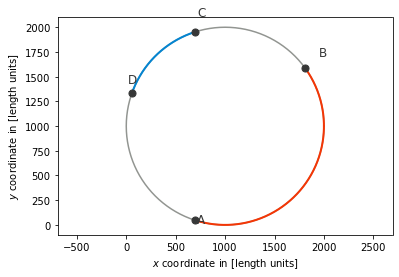

In [5]:
ml.plot()
plt.axis('equal')
plt.xlabel('$x$ coordinate in [length units]')
plt.ylabel('$y$ coordinate in [length units]')

## No-flow Boundary

With the base flow specified, we can start adding other flow-relevant things. As an example, we can add an internal no-flow boundary, representing a sheet wall or an impermeable geological formulation (if the element is line is closed). A no-flow boundary has the following parameters:

 - `model` - the model object to which this element will be added
 - `line` - a complex vector or real N-by-2 array specifying the vertices of the no-flow boundary
 - `segments` - most line or polygonal elements only work if their resolution is sufficiently fine; however, the element we specified below has only three segments; specifying `segments` > 3 subdivides the specified line and increases the element's resolution, at greater computational expense


In [6]:
ElementNoFlowBoundary(
    model           = ml,
    line            = np.asarray([850+1720j,1350+1450j,1400+1100j,1650+900j]),
    segments        = 100)

Let's plot the progress:

Text(0, 0.5, '$y$ coordinate in [length units]')

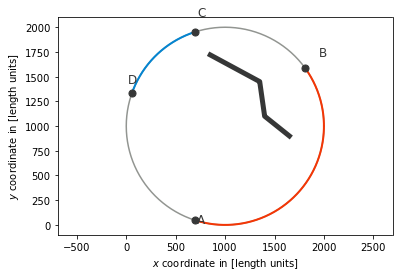

In [7]:
ml.plot()
plt.axis('equal')
plt.xlabel('$x$ coordinate in [length units]')
plt.ylabel('$y$ coordinate in [length units]')

## Extraction Well

We might also be interested in adding an extraction well. An extraction well
usually requires the following parameters:

 - `model` - the model object to which this element will be added
 - `zc` - xy coordinates of the well
 - `rw` - the screen radius of the well in [length units]
 - `strength` - extraction or injection rate of the well in [length units]^3/[time units]

In [8]:
ElementWell(
    model           = ml,
    zc              = [1200,1300],
    rw              = 0.2,
    strength        = -1E-2)

Let's plot the progress:

Text(0, 0.5, '$y$ coordinate in [length units]')

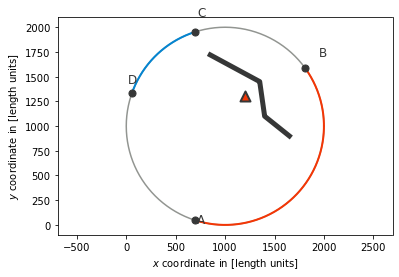

In [9]:
ml.plot()
plt.axis('equal')
plt.xlabel('$x$ coordinate in [length units]')
plt.ylabel('$y$ coordinate in [length units]')

## Prescribed Head Boundary

It is also possible to add prescribed head boundary conditions. These are specified similarly to no-flow boundaries in that they require the 'line' variable and 'segments' for (optional) refinement; in addition, this element also requires a real vector of length N (where N is the number of vertices in the 'line' variable) which specifies the enforced hydraulic head. It is also possible to specify the connectivity of the aquifer to the river through the optional 'connectivity' variable (between 0 and 1), which can be relevant for rivers with imperfect hydraulic connection. In this tutorial, we will only consider the simplest setup:

 - `model` - the model object to which this element will be added
 - `line` - a complex vector or real N-by-2 array specifying the vertices of the no-flow boundary
 - `line_ht` - a real vector of length N specifying the hydraulic heads enforced at the boundary's vertices
 - `segments` - most line or polygonal elements only work if their resolution is sufficiently fine; however, the element we specified below has only two segments; specifying `segments` > 2 subdivides the specified line and increases the element's resolution, at greater computational expense
 - `connectivity` - either a scalar or a vector defining the connectivity of this prescribed head boundary on the aquifer. The connectivity must be between zero (the boundary has no effect on the water table) and one (the boundary locally controls the water table). If a scalar is provided, the connectivity is uniform. If a vector is provided, the connectivity is spatially varying. In this case, we must also specify `connectivity_normdist`.
 - `connectivity_normdist` - a vector defining the position of the connectivity control points along the element (from zero to one) between which we interpolate the connectivity values, if `connectivity` is a vector; must be the same length as `connectivity`


In [10]:
ElementHeadBoundary(
    model                   = ml,
    line                    = np.asarray([300+750j,650+350j]),
    line_ht                 = np.asarray([123,125]),
    segments                = 100,
    connectivity            = np.asarray([0.5,1.0]),
    connectivity_normdist   = np.asarray([0.,1.]))

Let's plot the progress:

Text(0, 0.5, '$y$ coordinate in [length units]')

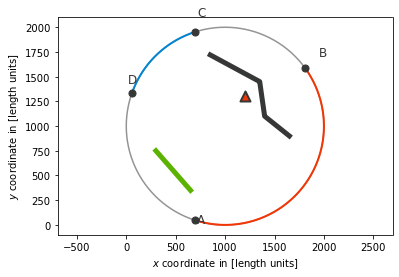

In [11]:
ml.plot()
plt.axis('equal')
plt.xlabel('$x$ coordinate in [length units]')
plt.ylabel('$y$ coordinate in [length units]')

## Polygonal Inhomogeneity

Polygonal or zonal inhomogeneities are a further common occurrence in hydrogeological models. The simplest set of parameters this element requires is a polygon (which is automatically closed, if it isn't already defined as such), an interior hydraulic conductivity, and an (optional) segments variable used for refinement:

 - `polygon` - a complex vector or real N-by-2 array specifying the vertices of the polygon
 - `k` - interior hydraulic conductivity in [length units]/[time units]
 - `segments` - most line or polygonal elements only work if their resolution is sufficiently fine; however, the element we specified below has only four segments; specifying `segments` > 4 subdivides the specified line and increases the element's resolution, at greater computational expense
 - `snap` - boolean flag (default: True) which decides whether points outside the model domain should be snapped to the domain's edge.
 - `snap_distance` - a very small scalar (default: 1E-10) with snaps evaluation points to the inhomogeneity if they get too close to the element. I don't recommend changing this value.

In [12]:
ElementInhomogeneity(
    model           = ml,
    polygon         = np.asarray([1000+1000j,700+700j,1000+400j,1300+700j]),
    k               = 1E-5,
    segments        = 100)

Let's plot the progress:

Text(0, 0.5, '$y$ coordinate in [length units]')

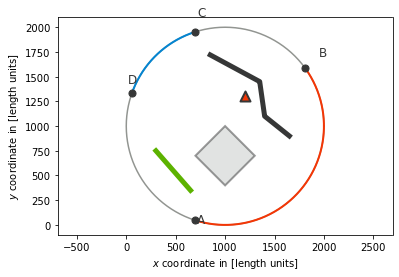

In [13]:
ml.plot()
plt.axis('equal')
plt.xlabel('$x$ coordinate in [length units]')
plt.ylabel('$y$ coordinate in [length units]')

## Simulation and plotting

One of the advantages of AEM is that the evaluation points are not bound to a numerical grid. As a consequence, we can decide on where we want to evaluate the model after we have defined it. To create equidistant points in a circular model domain, we have added a convenient function to the AEM toolbox. This function has the following parameters:

 - `rings` - number of rings on which equidistant points are placed; the more rings, the more points
 - `radius` - radius by which the unit disk is scaled
 - `offset` - real vector of length 2 or complex scalar, specifying the model domain offset

In [14]:
XY  = equidistant_points_in_circle(
    rings           = 51,
    radius          = ml.domain_radius,
    offset          = ml.domain_center)

To simulate, simply call the evaluate function of the model object. To use this function, we must pass a complex vector or real N-by-2 array specifying the evaluation points and the mode for which we want to solve. For classic hydrogeological modelling, the mode will be 'head'. This mode returns complex numbers whose real parts are the desired heads, and whose imaginary parts are the corresponding stream functions.
Other choices are 'potential' (which returns the complex potential Ω) or 'gradient' (which returns the derivative of the complex potential dΩ/dz); if 'gradient' is used, we can further specify if we want to extract certain partial derivatives by  specifying the additional argument 'derivatives', which takes as input either 'phi' (hydraulic potential) or 'psi' (stream 
function), in which case the real and imaginary parts correspond to the partial derivatives in x and y, respectively. 

The most basic parameters, however, are:

 - `z` - complex vector or real N-by-2 array containing the evaluation points
 - `mode` - string specifying the evaluation mode; either 'head', 'potential', or 'gradient'
 - `derivatives` - string specifying the type of desired derivatives if mode is set to 'gradient': returns either phi/psi for 'all', x/y components for 'phi', or x/y components for 'psi'

In [15]:
z   = ml.evaluate(
    z               = XY,
    mode            = 'head')

Since our evaluation points are not positioned on a regular grid, the normal plt.contour function won't work. Fortunately, pyplot has a 'tricontour' function which first triangulates between the points, then plots the contours. For this function, we need to provide the x and y coordinates and the hydraulic head estimates (the real part of z); we can also specify a 
desired number of contour levels, and the priority with which the contours should be plotted.

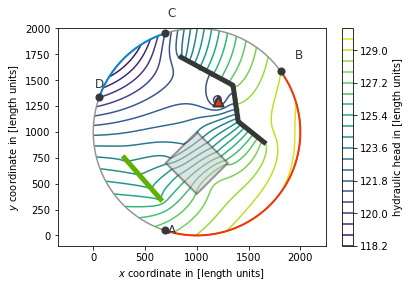

In [18]:
ml.plot()
plt.axis('equal')
plt.xlabel('$x$ coordinate in [length units]')
plt.ylabel('$y$ coordinate in [length units]')
plt.tricontour(
    XY[:,0],
    XY[:,1],
    np.real(z),
    levels          = 21,
    zorder          = -1)
plt.colorbar(label='hydraulic head in [length units]')

We can also add the stream function to this plot, which shows that the flow paths (indicated by the stream function) can be analytically evaluated. The strange artifacts to the West of the well and North-West of the prescribed head boundary are so-called 'branch cuts', which occur whenever an element adds or removes water from the system. This discontinuities in the stream function are unfortunately unavoidable, but since their positions are known, they can be removed from the plot with special routines.

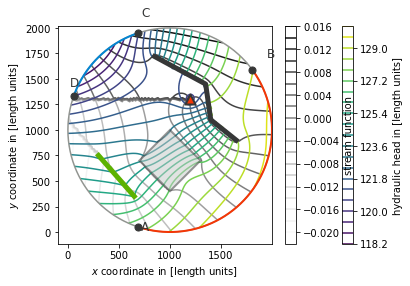

In [19]:
ml.plot()
plt.axis('equal')
plt.xlabel('$x$ coordinate in [length units]')
plt.ylabel('$y$ coordinate in [length units]')
plt.tricontour(
    XY[:,0],
    XY[:,1],
    np.real(z),
    levels          = 21,
    zorder          = -1)
plt.colorbar(label='hydraulic head in [length units]')

# This part is new
plt.tricontour(
    XY[:,0],
    XY[:,1],
    np.imag(z),
    levels          = 21,
    zorder          = -2,
    cmap            = 'Greys')
plt.colorbar(label='stream function')

With this, we are done! Continue to the second tutorial for instructions in how to extend this toolbox to uncertainty estimation.